In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cmdstanpy
import numpy as np
import cmdstanpy
cmdstanpy.install_cmdstan(compiler=True)
import os
import json

os.cpu_count()

16:20:07 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\dimot\.cmdstan\RTools40


CmdStan install directory: C:\Users\dimot\.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


12

#### Logit Binario

In [15]:
op_sample = pd.read_csv("data/instacart/order_product_sample.csv")
o_sample = pd.read_csv("data/instacart/orders_sample.csv")
p_sample = pd.read_csv("data/instacart/products_sample.csv")
op_sample = op_sample.merge(p_sample[["product_id", "aisle_id"]])

In [16]:
test_orders = o_sample.groupby("user_id",as_index=False).agg({"order_id":"last"})["order_id"].unique().tolist()
with open('data/instacart/test_orders.json', 'w', encoding='utf-8') as f:
    json.dump(test_orders, f)
# Creamos el diccionario para los nodos (productos)
df_products = p_sample[["aisle_id", "department"]].copy()
#df_products["aisle"] = df_products.aisle.apply(lambda x: "aisle:"+x)
df_products["department"] = df_products.department.apply(lambda x: "department:"+x)
cat_cols = ["department"]
for col in cat_cols:
    ddummies = pd.get_dummies(df_products[col], dtype=int, drop_first=True)
    df_products = pd.concat([df_products, ddummies], axis=1)
    df_products.drop(columns=col, inplace=True)
products = df_products.drop_duplicates().set_index("aisle_id").to_dict(orient="index")

# Creamos los diccionarios para los enlaces (compras)
orders_attr = o_sample[~o_sample["order_id"].isin(test_orders)].copy().drop(columns=["order_number", "lunes", "am"]).set_index("order_id").to_dict(orient="index")
orders_nodes = op_sample[~op_sample["order_id"].isin(test_orders)].copy().groupby("order_id")["aisle_id"].apply(list).to_dict()

In [17]:
y = []
u = []
w = []
i = []
j = []

for order in orders_attr.keys():
    P = orders_nodes[order]
    for prod in products.keys():
        if prod in P: y_ = 1
        else: y_ = 0

        u_ = list(products[prod].values())
        w_ = list(orders_attr[order].values())[1:]
        i_ = prod
        j_ = orders_attr[order]["user_id"]

        y.append(y_)
        u.append(u_)
        w.append(w_)
        i.append(i_)
        j.append(j_)

N = len(y)
U = len(u[0])
W = len(w[0])
I = len(products)
J = len(o_sample.user_id.unique())
x = [list(products[i].values()) for i in products.keys()]

cmdstanpy.write_stan_json("stan_models/instacart_data.json", {"N":N, "U":U, "W":W, "I":I, "J":J, "u":u, "x":x, "w":w, "i":i, "j":j, "y":y})
print((N,I,J,U,W))

(19493, 101, 15, 18, 7)


In [18]:
stan_model = cmdstanpy.CmdStanModel(stan_file=os.path.join("stan_models",'logit.stan'), force_compile=True
                                    )

fit = stan_model.sample(
    data="stan_models/instacart_data.json",
    chains=4,
    iter_sampling=1000,
    iter_warmup=500,
    seed=12345#, show_console=True
)

19:21:11 - cmdstanpy - INFO - compiling stan file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\logit.stan to exe file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\logit.exe
19:21:37 - cmdstanpy - INFO - compiled model executable: C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\logit.exe
19:21:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:34:41 - cmdstanpy - INFO - CmdStan done processing.


19:34:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 divergent transitions (0.9%)
	Chain 3 had 10 divergent transitions (1.0%)
	Chain 4 had 72 divergent transitions (7.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [19]:
fit.save_csvfiles("stan_models/fitted_logit")

In [25]:
y = []
X=[]

for order in orders_attr.keys():
    y_ = len(orders_nodes[order])
    x_ = list(orders_attr[order].values())[1:]
    
    y.append(y_)
    X.append(x_)


N = len(y)
K = len(X[0])

cmdstanpy.write_stan_json("stan_models/IC_GP_data.json", {"N":N, "K":K, "X":X, "y":y})
print((N, K))

(193, 7)


In [27]:
stan_model = cmdstanpy.CmdStanModel(stan_file=os.path.join("stan_models",'gamma-poisson.stan'), force_compile=True
                                    )

fit_GP = stan_model.sample(
    data="stan_models/IC_GP_data.json",
    chains=4,
    iter_sampling=1000,
    iter_warmup=500,
    seed=12345#, show_console=True
)

21:22:07 - cmdstanpy - INFO - compiling stan file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\gamma-poisson.stan to exe file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\gamma-poisson.exe
21:22:37 - cmdstanpy - INFO - compiled model executable: C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\gamma-poisson.exe
21:22:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:22:41 - cmdstanpy - INFO - CmdStan done processing.
21:22:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'gamma-poisson.stan', line 20, column 2 to column 20)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'gamma-poisson.stan', line 20, column 2 to column 20)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'gamma-poisson.stan', line 20, column 2 to column 20)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'gamma-poisson.stan', line 20, column 2 to column 20)
	Exception: gamma_lpdf: Shape parameter[1] is 0, but must be positive finite! (in 'gamma-poisson.stan', line 23, column 2 to column 32)
	Exception: gamma_lpdf: Shape parameter[1] is 0, but must be positive finite! (in 'gamma-poisson.stan', line 23, column 2 to column 32)
	Exception: gamma_lpdf: Random variable is inf, but must be positive

In [28]:
fit_GP.save_csvfiles("stan_models/fitted_gp")

#### ANálisis de datos (mover al otro archivo)

In [9]:
test_order = o_sample[o_sample["order_id"]==test_orders[0]]
test_user = test_order.user_id.values[0]
test_attr = test_order[["lunes", "martes", "miercoles", "jueves", "viernes", "sabado", "pm"]].values
print(test_user)

1


In [10]:
w_new = I * list(test_attr)
u_new = []
i_new = []
j_new = I * [test_user]
for s in products.keys():
    u_new.append(list(products[s].values()))
    i_new.append(s)

cmdstanpy.write_stan_json("stan_models/instacart_data_new.json", {"N":N, "U":U, "W":W, "I":I, "J":J, "u":u, "x":x, "w":w, "i":i, "j":j, "y":y, "N_new":I, "i_new":i_new, "j_new":j_new, "u_new":u_new, "w_new":w_new})

In [11]:
bernoulli_ppc_model = cmdstanpy.CmdStanModel(stan_file='stan_models/logit_ppc.stan', force_compile=True
                                             )
new_quantities = bernoulli_ppc_model.generate_quantities(data="stan_models/instacart_data_new.json", previous_fit=fit#, show_console=True
                                                         )

18:46:08 - cmdstanpy - INFO - compiling stan file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\logit_ppc.stan to exe file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\logit_ppc.exe
18:46:32 - cmdstanpy - INFO - compiled model executable: C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\logit_ppc.exe
18:46:32 - cmdstanpy - INFO - Chain [1] start processing
18:46:32 - cmdstanpy - INFO - Chain [2] start processing
18:46:32 - cmdstanpy - INFO - Chain [3] start processing
18:46:32 - cmdstanpy - INFO - Chain [4] start processing
18:46:34 - cmdstanpy - INFO - Chain [4] done processing
18:46:34 - cmdstanpy - INFO - Chain [1] done processing
18:46:34 - cmdstanpy - INFO - Chain [2] done processing
18:46:34 - cmdstanpy - INFO - Chain [3] done processing


In [12]:
import networkx as nx
edges = []
for d in orders_nodes.keys():
    nodes = orders_nodes[d]
    for node1 in nodes:
        for node2 in nodes:
            if node1 != node2:
                edges.append((node1, node2))
G = nx.from_edgelist(edges)

layout = nx.spring_layout(k=5, iterations=2000, G=G)
#nx.draw(G, layout)

In [13]:
from scipy.stats import gaussian_kde
from tqdm import tqdm
p_sujeto = {}
r_sujeto = {}
u_sujeto = {}
ps = []
rs = []
us = []
for s in tqdm(products.keys()):
    kde = gaussian_kde(new_quantities.theta_sim.T[s-1])
    x_vals = np.linspace(0, 1, 1000)
    y_vals = kde(x_vals)
    p_sujeto[s] = {"p":x_vals[np.argmax(y_vals)]}
    r_sujeto[s] = {"r":np.diff(np.percentile(new_quantities.theta_sim.T[s-1], q=(5,95)))[0]}
    u_sujeto[s] = {"u":np.diff(np.percentile(new_quantities.u_sim.T[s-1], q=(5,95)))[0]}
    ps.append(new_quantities.y_sim.T[s-1].mean())
    rs.append(np.diff(np.percentile(new_quantities.theta_sim.T[s-1], q=(5,95)))[0])
    us.append(np.diff(np.percentile(new_quantities.u_sim.T[s-1], q=(5,95)))[0])

nx.set_node_attributes(G, p_sujeto)
nx.set_node_attributes(G, r_sujeto)
nx.set_node_attributes(G, u_sujeto)

100%|██████████| 85/85 [00:11<00:00,  7.67it/s]


Probabilidad míninma: 0.001001001001001001 & Probabilidad máxima: 0.6536536536536537
Rango de probabilidad míninmo: 0.023125437749999988 & Rango de probabilidad máximo: 0.3443361499999999


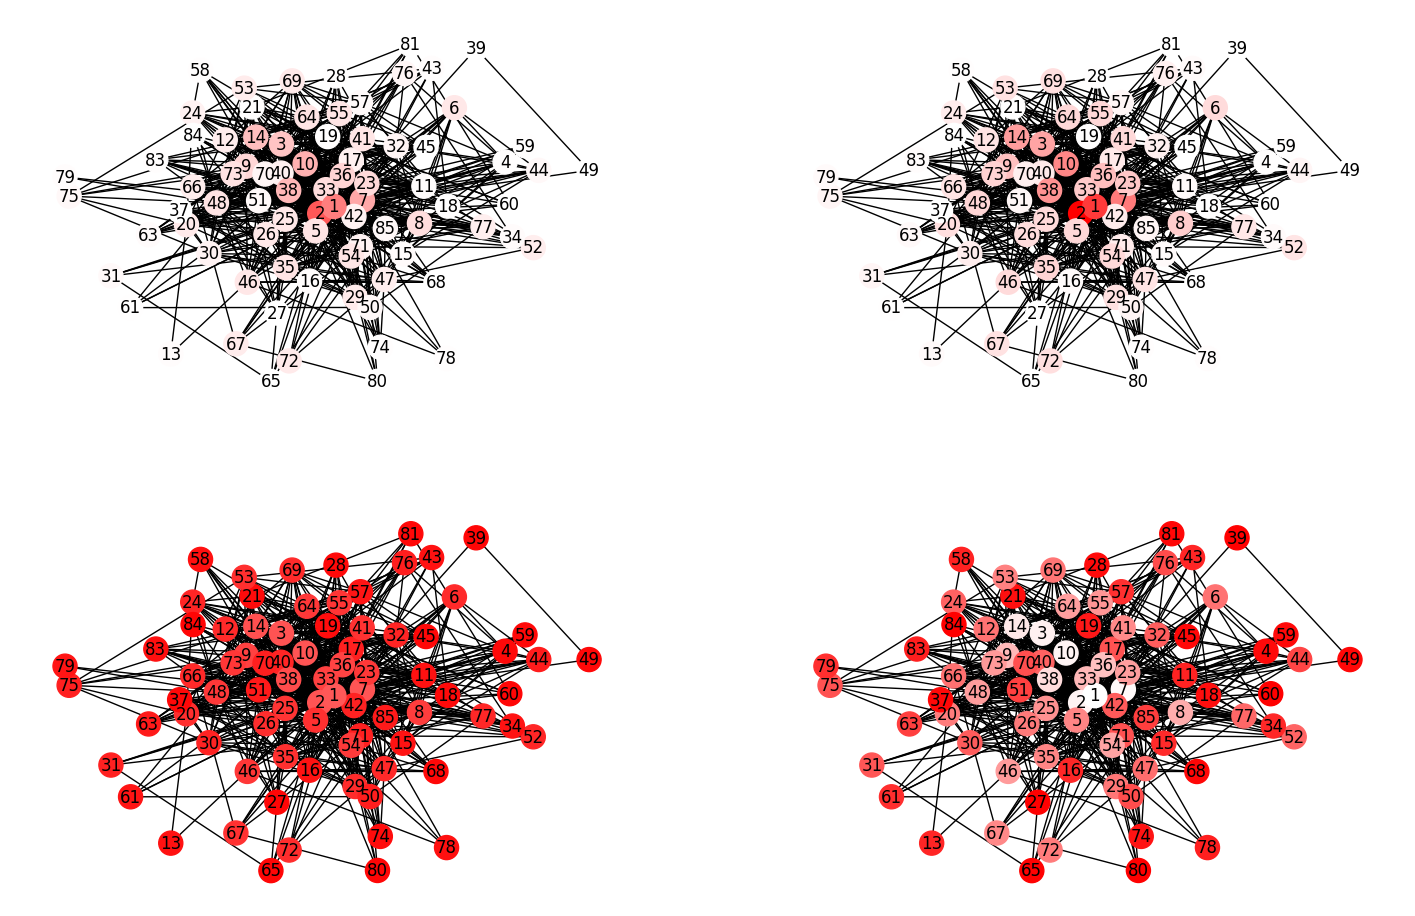

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable

# Crear colormap blanco → rojo
white_red = LinearSegmentedColormap.from_list("white_red", ["white", "red"])
red_white = LinearSegmentedColormap.from_list("red_white", ["red", "white"])
p_values = [G.nodes[n]["p"] for n in G.nodes]
r_values = [G.nodes[n]["r"] for n in G.nodes]
u_values = [G.nodes[n]["u"] for n in G.nodes]
pos = nx.spring_layout(G, k=2, iterations=100, seed=42)
plt.figure(figsize=(18,18))
plt.subplot(321)
nx.draw(
    G,
    node_color=p_values,
    cmap=white_red,     # azul-blanco-rojo
    vmin=0, vmax=1,      # escala entre 0 y 1
    with_labels=True,
    pos=pos
)
plt.subplot(322)
nx.draw(
    G,
    node_color=p_values,
    cmap=white_red,     # azul-blanco-rojo
    vmin=min(p_values), vmax=max(p_values),      # escala entre 0 y 1
    with_labels=True,
    pos=pos
)

plt.subplot(323)
nx.draw(
    G,
    node_color=r_values,
    cmap=red_white,     # azul-blanco-rojo
    vmin=0, vmax=1,      # escala entre 0 y 1
    with_labels=True,
    pos=pos
)

plt.subplot(324)
nx.draw(
    G,
    node_color=r_values,
    cmap=red_white,     # azul-blanco-rojo
    vmin=min(r_values), vmax=max(r_values),      # escala entre 0 y 1
    with_labels=True,
    pos=pos
)

print("Probabilidad míninma: " + str(min(p_values)) + " & Probabilidad máxima: " + str(max(p_values)))
print("Rango de probabilidad míninmo: " + str(min(r_values)) + " & Rango de probabilidad máximo: " + str(max(r_values)))
plt.show()

In [15]:
op_sample[op_sample.order_id.isin(test_order.order_id.values)]

,order_id,product_id,aisle_id
492,34,170,2
493,34,17,1
494,34,22,7
495,34,162,65
496,34,242,24


In [16]:
op_sample[op_sample["order_id"].isin(o_sample[o_sample["user_id"] == 1].order_id.unique())].groupby(["aisle_id"]).agg({"order_id":"size"})

,order_id
aisle_id,
1,7
2,7
4,3
5,1
6,1
7,5
8,2
11,2
13,2


In [19]:
op_sample[op_sample["order_id"].isin(o_sample[o_sample["user_id"] == 3].order_id.unique())].merge(p_sample[["product_id", "department"]], how="left", on="product_id").groupby(["department"]).agg({"order_id":"size"})

,order_id
department,
alcohol,2
bakery,3
beverages,14
breakfast,4
bulk,4
dry goods pasta,13
frozen,6
international,17
meat seafood,1


In [ ]:
op_sample[op_sample["order_id"].isin(o_sample[o_sample["user_id"] == 3].order_id.unique())].groupby(["aisle_id"]).agg({"order_id":"count"})